In [1]:
from jax.config import config
config.update("jax_enable_x64", True)
config.update('jax_platform_name', "cpu")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".4"

import time
import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
from jax import jit

import neurax as nx
from neurax.channels import HHChannel

In [4]:
i_delay = 3.0  # ms
i_amp = 1.0  # nA
i_dur = 2.0  # ms

dt = 0.025  # ms
t_max = 10.0  # ms
time_vec = jnp.arange(0.0, t_max+dt, dt)

### Compartment

In [5]:
comp = nx.Compartment().initialize()
comp.insert(HHChannel())

In [6]:
comp.set_params("length", 10.0)
comp.set_params("radius", 10.0)

comp.set_params("gNa", 0.120)
comp.set_params("gK", 0.036)
comp.set_params("gLeak", 0.0003)
comp.set_states("m", 0.07490098835688629)
comp.set_states("h", 0.488947681848153)
comp.set_states("n", 0.3644787002343737)
comp.set_states("voltages", -62.0)

In [7]:
stims = [nx.Stimulus(0, 0, 0.0, nx.step_current(i_delay, i_dur, i_amp, time_vec))]
recs = [nx.Recording(0, 0, 0.0)]

In [8]:
s = nx.integrate(comp, stims, recs, delta_t=dt)

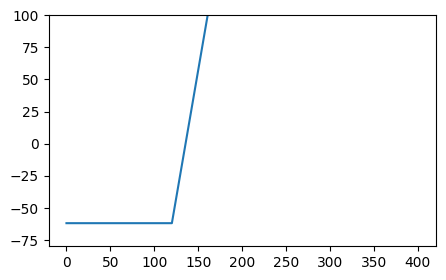

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
_ = ax.plot(s.T)
_ = ax.set_ylim([-80, 100])

### Branch

In [10]:
nseg_per_branch = 8

In [11]:
comp = nx.Compartment().initialize()
branch = nx.Branch([comp for _ in range(nseg_per_branch)])
branch.insert(HHChannel())

In [12]:
branch.set_params("length", 10.0)
branch.set_params("radius", 3.0)
branch.set_params("axial_resistivity", 1_000.0)

branch.set_params("gNa", 0.120)
branch.set_params("gK", 0.036)
branch.set_params("gLeak", 0.0003)
branch.set_states("m", 0.07490098835688629)
branch.set_states("h", 0.488947681848153)
branch.set_states("n", 0.3644787002343737)
branch.set_states("voltages", -62.0)

In [13]:
stims = [nx.Stimulus(0, 0, 0.0, nx.step_current(i_delay, i_dur, i_amp, time_vec))]
recs = [nx.Recording(0, 0, 0.0), nx.Recording(0, 0, 1.0)]

In [14]:
s = nx.integrate(branch, stims, recs, delta_t=dt)

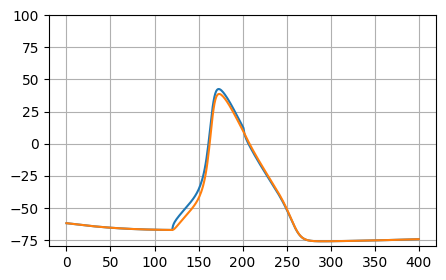

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
_ = ax.plot(s.T[:-1])
_ = ax.set_ylim([-80, 100])
ax.grid()

### Branch with unequal radiuses

In [28]:
nseg_per_branch = 10

In [29]:
comp = nx.Compartment().initialize()
branch = nx.Branch([comp for _ in range(nseg_per_branch)]).initialize()
branch.insert(HHChannel())

In [30]:
radiuses = np.concatenate([np.asarray([3.0]), np.linspace(3.0, 15.0, nseg_per_branch-2), np.asarray([15.0])])
for i, loc in enumerate(np.linspace(0, 1, nseg_per_branch)):
    branch.comp(loc).set_params("radius", radiuses[i])

branch.set_params("length", 10.0)
branch.comp(0.0).set_params("length", 0.0)
branch.comp(1.0).set_params("length", 0.0)
branch.set_params("axial_resistivity", 1_000.0)

branch.set_params("gNa", 0.120)
branch.set_params("gK", 0.036)
branch.set_params("gLeak", 0.0003)
branch.set_states("m", 0.07490098835688629)
branch.set_states("h", 0.488947681848153)
branch.set_states("n", 0.3644787002343737)
branch.set_states("voltages", -62.0)

In [31]:
stims = [nx.Stimulus(0, 0, 0.0, nx.step_current(i_delay, i_dur, i_amp, time_vec))]
recs = [nx.Recording(0, 0, 0.0), nx.Recording(0, 0, 1.0)]

In [32]:
s = nx.integrate(branch, stims, recs, delta_t=dt, tridiag_solver="thomas")

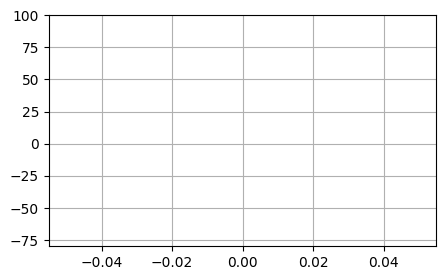

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
_ = ax.plot(time_vec, s.T[:-1])
_ = ax.set_ylim([-80, 100])
ax.grid()

### Cell

In [39]:
nseg_per_branch = 8

In [40]:
comp = nx.Compartment().initialize()
branch = nx.Branch([comp for _ in range(nseg_per_branch)]).initialize()
cell = nx.Cell([branch for _ in range(3)], parents=[-1, 0, 0]).initialize()
cell.insert(HHChannel())

In [41]:
cell.set_params("radius", 5.0)
cell.set_params("length", 10.0)
cell.set_params("axial_resistivity", 1_000.0)

cell.set_params("gNa", 0.120)
cell.set_params("gK", 0.036)
cell.set_params("gLeak", 0.0003)
cell.set_states("m", 0.07490098835688629)
cell.set_states("h", 0.488947681848153)
cell.set_states("n", 0.3644787002343737)
cell.set_states("voltages", -62.0)

In [42]:
stims = [nx.Stimulus(0, 0, 0.0, nx.step_current(i_delay, i_dur, i_amp, time_vec))]
recs = [nx.Recording(0, 0, 0.0), nx.Recording(0, 1, 1.0), nx.Recording(0, 2, 1.0)]

In [43]:
s = nx.integrate(cell, stims, recs, delta_t=dt)

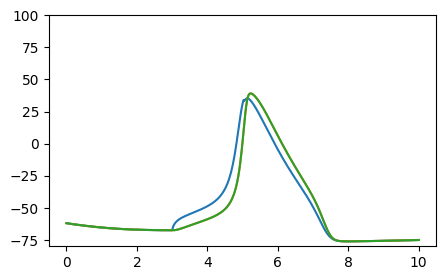

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
_ = ax.plot(time_vec, s.T[:-1])
_ = ax.set_ylim([-80, 100])